In [1]:
# !pip install matplotlib
# !pip install tensorflow
# !pip install tensorflow-gpu==2.12.0

In [1]:
import sys
print(sys.version)

3.10.0 | packaged by conda-forge | (default, Nov 10 2021, 13:20:59) [MSC v.1916 64 bit (AMD64)]


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
print(tf.__version__)
print(tf.keras.__version__)

2.10.0
2.10.0


In [4]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [7]:
# image size 
IMAGE_SIZE = 256
 
# Batch size
BATCH_SIZE = 32

# CHANNELS
CHANELS = 3

# EPOCHS
EPOCHS = 30

### Loading data from harddisk

In [8]:
## load dataset form derectory into tensorflow

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset) # 32*68

68

### Visualizing the data

In [11]:
# for image_batch, label_batch in dataset.take(1): # we will load batch 1
#     print(image_batch.shape)  # (batch_size, image_size, image_size, RGB) == (32, 256, 256, 3)
#     print(label_batch.numpy())    

In [12]:
# for image_batch, label_batch in dataset.take(1): # we will load batch 1
#     print(image_batch[0].shape) 
#     print(image_batch[0].numpy())

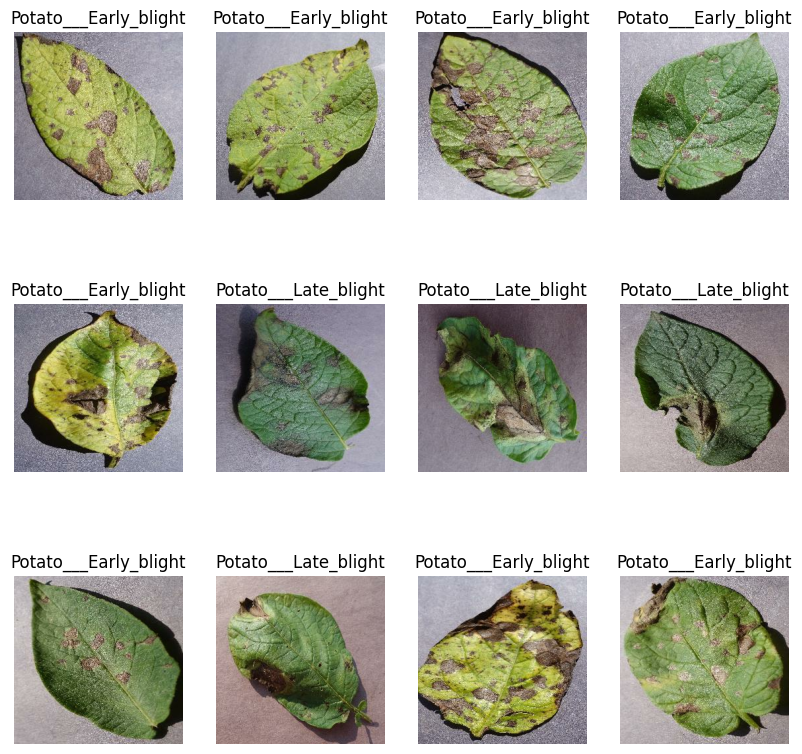

In [13]:
## visualizing the image
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1): # we will load batch 1
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

### Splititng dataset

In [14]:
len(dataset)

68

In [15]:
### train test split
# 80% --> training
# 20% --> 10 % validation, 10% test

In [16]:
# training data
train_size = 0.8 # 80% 
train_size = len(dataset)*train_size
print("Training size : {}".format(train_size))

# validation data
val_size = 0.1
val_size = len(dataset)*val_size
print("validation size : {}".format(val_size))

# testing size
test_size = 0.1
test_size=len(dataset)*test_size
print("Testing size : {}".format(test_size))

Training size : 54.400000000000006
validation size : 6.800000000000001
Testing size : 6.800000000000001


In [17]:
# training data
train_ds = dataset.take(54)  #array[:54]
print("Training dataset size : {}".format(len(train_ds)))


# testing data
test_ds = dataset.skip(54) #array[54:]
print("Testing dataset size : {}".format(len(test_ds)))

#-------------------------------------------------------------

# validation data
val_ds = test_ds.take(6)
print("validation dataset size : {}".format(len(val_ds)))

# testing data
test_ds = test_ds.skip(6)
print("Testing dataset size : {}".format(len(test_ds)))

Training dataset size : 54
Testing dataset size : 14
validation dataset size : 6
Testing dataset size : 8


In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split = 0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
print(f"training_size : {len(train_ds)}\nvalidation_size : {len(val_ds)}\ntesting_size : {len(test_ds)}")

training_size : 54
validation_size : 6
testing_size : 8


In [21]:
# This way we are optimizing our model

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### lmage Preprocessing

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# 1. layer :- during training if some images are not having size 256x256 then this 1st layer will take care of that error
# 2. This 2nd layer will simply resize the image that means it will do feature scalling 

### Data Agumentation

In [23]:
data_agumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

## Model Building
### Implimetation of CNN

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_agumentation,
    layers.Conv2D(filters=32,kernel_size=(3,3), activation="relu",input_shape=input_shape),  
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(units=64, activation="relu"),
    layers.Dense(units=n_classes, activation='softmax')
])

model.build(input_shape=input_shape )

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
54/54 [==============================] - 54s 465ms/step - loss: 2.0967 - accuracy: 0.5532 - val_loss: 0.8500 - val_accuracy: 0.4948
Epoch 2/30
54/54 [==============================] - 24s 443ms/step - loss: 0.5815 - accuracy: 0.7280 - val_loss: 0.4381 - val_accuracy: 0.8438
Epoch 3/30
54/54 [==============================] - 23s 431ms/step - loss: 0.4031 - accuracy: 0.8362 - val_loss: 0.8119 - val_accuracy: 0.5781
Epoch 4/30
54/54 [==============================] - 23s 431ms/step - loss: 0.4671 - accuracy: 0.7940 - val_loss: 0.2876 - val_accuracy: 0.8646
Epoch 5/30
54/54 [==============================] - 23s 430ms/step - loss: 0.3460 - accuracy: 0.8542 - val_loss: 0.2976 - val_accuracy: 0.8646
Epoch 6/30
54/54 [==============================] - 24s 437ms/step - loss: 0.2436 - accuracy: 0.9022 - val_loss: 0.2036 - val_accuracy: 0.9271
Epoch 7/30
54/54 [==============================] - 24s 443ms/step - loss: 0.2103 - accuracy: 0.9138 - val_loss: 0.2198 - val_accuracy: 0.9115

### Evaluating Model

In [ ]:
model.evaluate(train_ds)

In [ ]:
model.evaluate(test_ds)

#### History

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

### Ploting Training and Validation Accuracy 

In [ ]:
acc =history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training loss")
plt.plot(range(EPOCHS), val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation losses")
plt.show()

## Predictions

In [ ]:
import numpy as np

plt.figure(figsize=(10,5))
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()
                              
    print(plt.imshow(first_image))
    print("image Label :- ",class_names[first_label])
    
    ## prediction
    batch_prediction = model.predict(image_batch)
    result = np.argmax(batch_prediction[0])
    print(f"Batch Predictions:- {class_names[result]}")

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array,0) # create a batch

    prediction = model.predict(img_array)
    
    result = np.argmax(batch_prediction[0])
    prediction_class = class_names[result]
    
    confidence = round(100 * (np.max(prediction[0])),2)
    return prediction_class, confidence

In [ ]:
plt.figure(figsize=(20,20))
for image, label in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        
        prediction_class, confidence = predict(model, image[i].numpy())
        actual_class = class_names[label[i]]
        
        plt.title(f"Actual :{actual_class}, \nPrediction : {prediction_class}, \nConfidence : {confidence}%")
        plt.axis("off")

In [ ]:
model_version = 2
model.save(f"My_Model/{model_version}")